# Replicability analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
import numpy as np
import scipy.stats as stats
import scipy.spatial as spatial
import scanpy as sc

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.7-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
full_df = pd.read_csv('MAST_full.csv', index_col=0)
full_df.columns =  ['gene', 'pval', 'coef', 'ci_hi', 'ci_io', 'fdr']

In [4]:
full_de_genes = set(full_df.query('fdr < 0.05').gene.tolist())

In [5]:
data_path = '/data_volume/memento/method_comparison/'

In [68]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'axes.labelsize': 'large'}
pylab.rcParams.update(params)

In [7]:
def concordance(x, y, log=False):
    nonnan = np.isfinite(x) & np.isfinite(y)
    
    if log:
        a = np.log(x)
        b = np.log(y)
    else:
        a = x
        b = y
    cond = np.isfinite(a) & np.isfinite(b)
    a = a[cond]
    b = b[cond]
    cmat = np.cov(a, b)
    return 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

### Run memento on full and partial datasets

In [26]:
ifnb_df = pd.read_csv(data_path + 'mast/seurat_full.csv', index_col=0)
seurat_cells = ifnb_df.index.map(lambda x: '-'.join(x.split('.')))
seurat_genes = pd.read_csv(data_path + 'mast/seurat_genes.csv', index_col=0)['x']\
    .map(lambda x: '-'.join(x.split('.'))).tolist()


In [29]:
adata = sc.read('/data_volume/memento/demux/interferon.h5ad')
adata.var.index = adata.var.index.map(lambda x: '-'.join(x.split('.')))
adata.var.rename(index={'Y_RNA':'Y-RNA'}, inplace=True)
adata = adata[seurat_cells,  seurat_genes].copy().copy()
adata.obs['q'] = 0.1
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07,trim_percent=0.1)


In [30]:
memento.create_groups(adata, label_columns=['stim'])
memento.compute_1d_moments(adata, filter_genes=True)
memento.ht_1d_moments(
    adata, 
    formula_like='1 + stim',
    treatment_col='stim', 
    num_boot=50000, 
    verbose=1,
    num_cpus=93,
    resampling='bootstrap',
    approx=True)

   stim
0  ctrl
1  stim


[Parallel(n_jobs=93)]: Using backend LokyBackend with 93 concurrent workers.
[Parallel(n_jobs=93)]: Done  14 tasks      | elapsed:    9.6s
[Parallel(n_jobs=93)]: Done 264 tasks      | elapsed:   41.1s
[Parallel(n_jobs=93)]: Done 614 tasks      | elapsed:  1.2min
[Parallel(n_jobs=93)]: Done 1064 tasks      | elapsed:  1.9min
[Parallel(n_jobs=93)]: Done 1614 tasks      | elapsed:  2.7min
[Parallel(n_jobs=93)]: Done 2032 out of 2032 | elapsed:  3.5min finished


In [31]:
adata_sample_1 = sc.pp.subsample(adata, n_obs=250, copy=True, random_state=None).copy().copy()
# memento.setup_memento(adata_sample_1, q_column='q', filter_mean_thresh=0.07,trim_percent=0.1)

memento.create_groups(adata_sample_1, label_columns=['stim'])
memento.compute_1d_moments(adata_sample_1, filter_genes=True)
memento.ht_1d_moments(
    adata_sample_1, 
    formula_like='1 + stim',
    treatment_col='stim', 
    num_boot=50000, 
    verbose=1,
    num_cpus=14,
    resampling='bootstrap',
    approx=True)

   stim
0  ctrl
1  stim


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    1.3s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    7.5s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:   17.5s
[Parallel(n_jobs=14)]: Done 772 tasks      | elapsed:   32.2s
[Parallel(n_jobs=14)]: Done 1222 tasks      | elapsed:   51.0s
[Parallel(n_jobs=14)]: Done 1632 out of 1632 | elapsed:  1.1min finished


In [32]:
adata_sample_2 = sc.pp.subsample(adata, n_obs=250, copy=True, random_state=None).copy().copy()
# memento.setup_memento(adata_sample_2, q_column='q', filter_mean_thresh=0.07,trim_percent=0.1)

memento.create_groups(adata_sample_2, label_columns=['stim'])
memento.compute_1d_moments(adata_sample_2, filter_genes=True)
memento.ht_1d_moments(
    adata_sample_2, 
    formula_like='1 + stim',
    treatment_col='stim', 
    num_boot=50000, 
    verbose=1,
    num_cpus=14,
    resampling='bootstrap',
    approx=True)

   stim
0  stim
1  ctrl


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    1.1s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    7.2s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:   16.9s
[Parallel(n_jobs=14)]: Done 772 tasks      | elapsed:   31.3s
[Parallel(n_jobs=14)]: Done 1222 tasks      | elapsed:   49.8s
[Parallel(n_jobs=14)]: Done 1603 out of 1603 | elapsed:  1.1min finished


In [33]:
adata.obs.to_csv(data_path + 'memento/meta_full.csv')
adata_sample_1.obs.to_csv(data_path + 'memento/meta_equal_rep_1.csv')
adata_sample_2.obs.to_csv(data_path + 'memento/meta_equal_rep_2.csv')

In [34]:
ht = memento.get_1d_ht_result(adata)
ht1 = memento.get_1d_ht_result(adata_sample_1)
ht2 = memento.get_1d_ht_result(adata_sample_2)

In [35]:
ht.to_csv(data_path + 'memento/memento_full.csv', index=False)
ht1.to_csv(data_path + 'memento/memento_equal_rep_1.csv', index=False)
ht2.to_csv(data_path + 'memento/memento_equal_rep_2.csv', index=False)

### Run (in other notebook) and read MAST results

In [36]:
df1 = pd.read_csv(data_path + 'mast/MAST_equal_rep_1.csv', index_col=0)
df2 = pd.read_csv(data_path + 'mast/MAST_equal_rep_2.csv', index_col=0)

### Comparing t-statistics

In [40]:
joined_mast = df1.merge(df2, on='primerid')
joined = ht1.merge(ht2, on='gene')
gene_overlap = set(joined_mast['primerid']) & set(joined['gene'])
joined_mast = joined_mast.query('primerid in @gene_overlap')
joined = joined.query('gene in @gene_overlap')

0.7166933272801614
0.9188015828631254


Text(0.5, 0, 'Subset 1 S.E.')

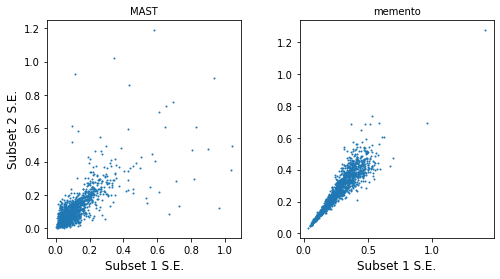

In [41]:
plt.figure(figsize=(8,4))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 2, 1)
a = (joined_mast['ci.hi_x']-joined_mast['coef_x'].values)/2
b = (joined_mast['ci.hi_y']-joined_mast['coef_y'].values)/2
isf = np.isfinite(a) & np.isfinite(b)
print(concordance(a[isf], b[isf]))
plt.scatter(a, b, s=1)
plt.title('MAST')
plt.xlabel('Subset 1 S.E.')
plt.ylabel('Subset 2 S.E.')

plt.subplot(1, 2, 2)

a = (joined['de_se_x'])
b = (joined['de_se_y'])
isf = np.isfinite(a) & np.isfinite(b)
print(concordance(a[isf], b[isf]))
plt.scatter(a, b, s=1)
plt.title('memento')
plt.xlabel('Subset 1 S.E.')
# plt.ylabel('Subset 2 S.E.')

0.7177871350565989
0.9622750149317797


Text(0.5, 0, 'Subset 1 S.E.')

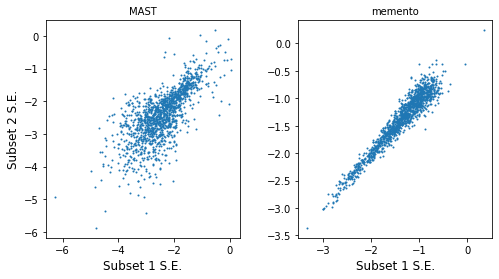

In [42]:
plt.figure(figsize=(8,4))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 2, 1)
a = np.log((joined_mast['ci.hi_x']-joined_mast['coef_x'].values)/2)
b = np.log((joined_mast['ci.hi_y']-joined_mast['coef_y'].values)/2)
isf = np.isfinite(a) & np.isfinite(b)
print(concordance(a[isf], b[isf]))
plt.scatter(a, b, s=1)
plt.title('MAST')
plt.xlabel('Subset 1 S.E.')
plt.ylabel('Subset 2 S.E.')

plt.subplot(1, 2, 2)

a = np.log(joined['de_se_x'])
b = np.log(joined['de_se_y'])
isf = np.isfinite(a) & np.isfinite(b)
print(concordance(a[isf], b[isf]))
plt.scatter(a, b, s=1)
plt.title('memento')
plt.xlabel('Subset 1 S.E.')
# plt.ylabel('Subset 2 S.E.')

0.9275128502610555
0.889432460727789


Text(0.5, 0, 'Subset 1 coefficient')

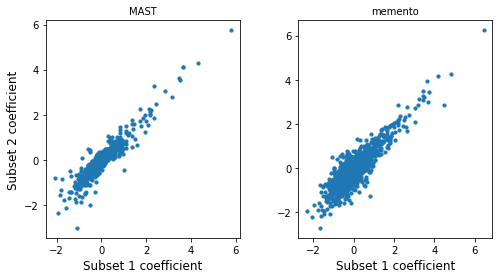

In [43]:
plt.figure(figsize=(8,4))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 2, 1)
a = joined_mast['coef_x']#/((df1['ci.hi']-df1['coef'].values)/2)
b = joined_mast['coef_y']#/((df2['ci.hi']-df2['coef'].values)/2)
isf = np.isfinite(a) & np.isfinite(b)
print(concordance(a[isf], b[isf]))

plt.scatter(a, b, s=10)
plt.title('MAST')
plt.xlabel('Subset 1 coefficient')
plt.ylabel('Subset 2 coefficient')

plt.subplot(1, 2, 2)

a = joined['de_coef_x']#/joined['de_se_x']#np.log((df1['ci.hi']-df1['coef'].values)/2)
b = joined['de_coef_y']#/joined['de_se_y']#np.log((df2['ci.hi']-df2['coef'].values)/2)
isf = np.isfinite(a) & np.isfinite(b)
print(concordance(a[isf], b[isf]))

plt.scatter(a, b, s=10)
plt.title('memento')
plt.xlabel('Subset 1 coefficient')
# plt.ylabel('Subset 2 S.E.')

0.9111397561086102
0.9274528818726544


Text(0.5, 0, 'Subset 1 t-statistic')

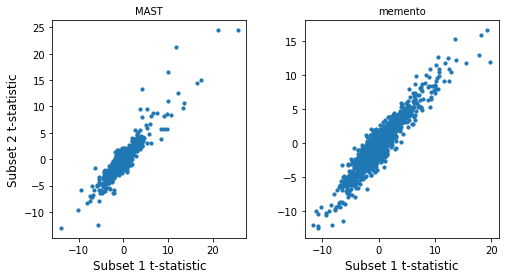

In [44]:
plt.figure(figsize=(8,4))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 2, 1)
a = joined_mast['coef_x']/((joined_mast['ci.hi_x']-joined_mast['coef_x'].values)/2)
b = joined_mast['coef_y']/((joined_mast['ci.hi_y']-joined_mast['coef_y'].values)/2)
isf = np.isfinite(a) & np.isfinite(b)
print(concordance(a[isf], b[isf]))

plt.scatter(a, b, s=10)
plt.title('MAST')
plt.xlabel('Subset 1 t-statistic')
plt.ylabel('Subset 2 t-statistic')

plt.subplot(1, 2, 2)

a = joined['de_coef_x']/joined['de_se_x']#np.log((df1['ci.hi']-df1['coef'].values)/2)
b = joined['de_coef_y']/joined['de_se_y']#np.log((df2['ci.hi']-df2['coef'].values)/2)
isf = np.isfinite(a) & np.isfinite(b)
print(concordance(a[isf], b[isf]))

plt.scatter(a, b, s=10)
plt.title('memento')
plt.xlabel('Subset 1 t-statistic')
# plt.ylabel('Subset 2 S.E.')

0.608924092346793
0.5546599635257964


Text(0.5, 0, 'Subset 1 FDR')

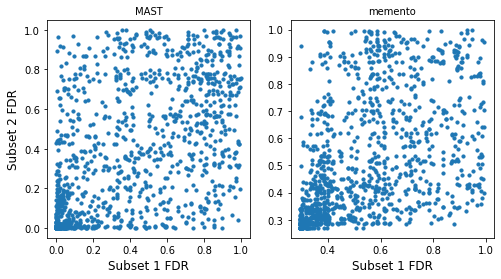

In [45]:
plt.figure(figsize=(8,4))
plt.subplots_adjust(wspace=0.2)
plt.subplot(1, 2, 1)
a = joined_mast['Pr(>Chisq)_x']#/((df1['ci.hi']-df1['coef'].values)/2)
b = joined_mast['Pr(>Chisq)_y']#/((df2['ci.hi']-df2['coef'].values)/2)

a = memento.util._fdrcorrect(a)
b = memento.util._fdrcorrect(b)

# a = -np.log10(a)
# b = -np.log10(b)

isf = np.isfinite(a) & np.isfinite(b)
print(concordance(a[isf], b[isf]))

plt.scatter(a, b, s=10)
plt.title('MAST')
plt.xlabel('Subset 1 FDR')
plt.ylabel('Subset 2 FDR')
# plt.ylim(-300, 0.5); plt.xlim(-300, 0.5)

plt.subplot(1, 2, 2)

a = joined['de_pval_x']#/joined['de_se_x']#np.log((df1['ci.hi']-df1['coef'].values)/2)
b = joined['de_pval_y']#/joined['de_se_y']#np.log((df2['ci.hi']-df2['coef'].values)/2)

a = memento.util._fdrcorrect(a)
b = memento.util._fdrcorrect(b)

# a = -np.log10(a)
# b = -np.log10(b)

isf = np.isfinite(a) & np.isfinite(b)
print(concordance(a[isf], b[isf]))

plt.scatter(a, b, s=10)
plt.title('memento')
plt.xlabel('Subset 1 FDR')
# plt.ylim(-300, 0.5); plt.xlim(-300, 0.5)

# plt.ylabel('Subset 2 S.E.')

In [46]:
cutoffs = np.logspace(-3,0, 50)
mast_dist = []
memento_dist = []

for cutoff in cutoffs:
    
    sig1 = (memento.util._fdrcorrect(joined_mast['Pr(>Chisq)_x']) < cutoff).astype(int)
    sig2 = memento.util._fdrcorrect((joined_mast['Pr(>Chisq)_y']) < cutoff).astype(int)
    mast_dist.append(np.mean(np.abs((sig1-sig2))))
    
    sig1 = (memento.util._fdrcorrect(joined['de_pval_x']) < cutoff).astype(int)
    sig2 = (memento.util._fdrcorrect(joined['de_pval_y']) < cutoff).astype(int)
    memento_dist.append(np.mean(np.abs((sig1-sig2))))
#     memento_dist.append(
#         spatial.distance.jaccard(joined['de_pval_x'] < cutoff, joined['de_pval_y'] < cutoff))

### Repeat the analysis with multiple matchups

In [ ]:
d1, d2 = 1, 2

df1 = pd.read_csv(data_path + 'MAST_equal_rep_{}.csv'.format(d1), index_col=0)
df2 = pd.read_csv(data_path + 'MAST_equal_rep_{}.csv'.format(d2), index_col=0)
joined_mast = df1.merge(df2, on='primerid')

df1 = pd.read_csv(data_path + 'memento_equal_rep_{}.csv'.format(d1), index_col=0)
df2 = pd.read_csv(data_path + 'memento_equal_rep_{}.csv'.format(d2), index_col=0)
joined = df1.merge(df2, on='gene')

cutoff = 0.1

sig = (joined_mast['Pr(>Chisq)_x'] < cutoff).astype(int)
scores = 1-(joined_mast['Pr(>Chisq)_y'])
fpr, tpr, _ = roc_curve(sig, scores)
plt.plot(fpr, tpr)

sig = (joined['de_pval_x'] < cutoff).astype(int)
scores = 1-(joined['de_pval_y'])

fpr, tpr, _ = roc_curve(sig, scores)
plt.plot(fpr, tpr)

### Comparing to the full dataset

In [59]:
overlap_genes = list(set(adata.var.index) & set(adata_sample_1.var.index))

In [60]:
ctrl_data = adata[adata.obs['stim'] == 'ctrl', overlap_genes].X.toarray()
stim_data = adata[adata.obs['stim'] == 'stim',  overlap_genes].X.toarray()

ctrl_data /= ctrl_data.sum(axis=1).reshape(-1,1)
stim_data /= stim_data.sum(axis=1).reshape(-1,1)

In [61]:
_, ttest_pv_full = stats.ttest_ind(ctrl_data, stim_data)
mwu_pv_full = np.array([stats.ranksums(ctrl_data[:, i], stim_data[:,i])[1] for i in range(ctrl_data.shape[1])])

In [62]:
sample_ctrl_data = adata_sample_1[adata_sample_1.obs['stim'] == 'ctrl', overlap_genes].X.toarray()
sample_stim_data = adata_sample_1[adata_sample_1.obs['stim'] == 'stim', overlap_genes].X.toarray()

sample_ctrl_data /= sample_ctrl_data.sum(axis=1).reshape(-1,1)
sample_stim_data /= sample_stim_data.sum(axis=1).reshape(-1,1)

In [63]:
_, ttest_pv_sample = stats.ttest_ind(sample_ctrl_data, sample_stim_data)
mwu_pv_sample = np.array([stats.ranksums(sample_ctrl_data[:, i], sample_stim_data[:,i])[1] for i in range(sample_ctrl_data.shape[1])])

In [64]:
memento_ht_partial = pd.read_csv(data_path + 'memento/memento_equal_rep_{}.csv'.format(1), index_col=0)
memento_ht_full = memento.get_1d_ht_result(adata)

In [65]:
mast_ht_partial = pd.read_csv(data_path + 'mast/MAST_equal_rep_{}.csv'.format(1), index_col=0)
mast_ht_full = pd.read_csv(data_path + 'mast/MAST_full_demux.csv', index_col=0)

In [66]:
memento_joined = memento_ht_partial.merge(memento_ht_full, on='gene', suffixes=('_partial', '_full'))
mast_joined = mast_ht_partial.merge(mast_ht_full, on='primerid', suffixes=('_partial', '_full'))

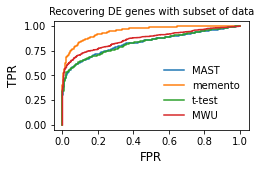

In [72]:
plt.figure(figsize=(3.5,2))
cutoff = 0.01

sig = (mast_joined['Pr(>Chisq)_full'] < cutoff).astype(int)
scores = 1-(mast_joined['Pr(>Chisq)_partial'])
fpr, tpr, _ = roc_curve(sig, scores)
plt.plot(fpr, tpr, label='MAST')

sig = (memento_joined['de_pval_full'] < cutoff).astype(int)
scores = 1-(memento_joined['de_pval_partial'])
fpr, tpr, _ = roc_curve(sig, scores)
plt.plot(fpr, tpr, label='memento')

sig = (ttest_pv_full < cutoff).astype(int)
# scores = np.random.random(size=len(sig))
scores = 1-ttest_pv_sample
fpr, tpr, _ = roc_curve(sig, scores)
plt.plot(fpr, tpr, label='t-test')

sig = (mwu_pv_full < cutoff).astype(int)
scores = 1-mwu_pv_sample
fpr, tpr, _ = roc_curve(sig, scores)
plt.plot(fpr, tpr, label='MWU')

plt.legend(frameon=False)

plt.title('Recovering DE genes with subset of data')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.savefig('de_recovery.pdf', bbox_inches='tight')